In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm import tqdm
import gdown

from aegear.model import EfficientUNet, SiameseTracker
from aegear.datasets import TrackingDataset

In [2]:
# 3. Download the data if not already in place
dataset_dir = '../data/training'
annotations_file = os.path.join(dataset_dir, 'tracking_E7_filtered.json')
video_dir = "../data/video"

os.makedirs(dataset_dir, exist_ok=True)

# Check if each of the dataset units is present
if not os.path.exists(annotations_file):
    print("Downloading dataset...")
    # Google Drive share link
    file_id = "1osZGb1Wc_iZ-mCAV54OhTwsmPN88nZ3y"
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, annotations_file, quiet=False)

if not os.path.exists(video_dir):
    print("Downloading video...")

    # Google Drive share link
    file_id = "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    url = f'https://drive.google.com/uc?id={file_id}'

    output = os.path.join(dataset_dir, "E7.MOV")
    gdown.download(url,output, quiet=False)

In [3]:
def get_confidence(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return heatmap[0, 0, y, x].item()

def overlay_heatmap_on_rgb(rgb_tensor, heatmap, alpha=0.5, centroid_color=(0, 1, 0)):
    """
    Overlay heatmap onto RGB image and draw a circle at the predicted centroid.
    
    Args:
        rgb_tensor: [3, H, W] tensor
        heatmap: [H, W] numpy array
        alpha: blending weight
        centroid_color: (R, G, B) tuple in range 0–1
    Returns:
        overlay: [H, W, 3] numpy image
    """
    rgb = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    rgb = rgb * 0.229 + 0.485
    rgb = rgb.clip(0, 1)

    heatmap_color = plt.cm.hot(heatmap)[..., :3]
    overlay = (1 - alpha) * rgb + alpha * heatmap_color

    # Find centroid
    flat_idx = heatmap.reshape(-1).argmax()
    h, w = heatmap.shape
    cy = flat_idx // w
    cx = flat_idx % w

    # Draw circle
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    cx_int, cy_int = int(cx), int(cy)
    color_bgr = tuple(int(c * 255) for c in reversed(centroid_color))
    cv2.circle(overlay_uint8, (cx_int, cy_int), 4, color_bgr, thickness=1)

    return overlay_uint8 / 255.0

def save_epoch_visualization(model, val_dataset, epoch, device, output_dir="vis_epochs", N=5, val_seed=42):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    samples = []
    fig, axes = plt.subplots(N, 3, figsize=(9, 3 * N))

    with torch.no_grad():
        for i in range(N):
            random.seed(val_seed)
            template, search, heatmap = val_dataset[i]

            # Move to device, add batch dim
            template_batch = template.unsqueeze(0).to(device)
            search_batch = search.unsqueeze(0).to(device)

            pred = torch.sigmoid(model(template_batch, search_batch))
            confidence = get_confidence(pred)

            # Resize heatmaps to match input size
            target_hm = F.interpolate(heatmap.unsqueeze(0), size=template.shape[-2:], mode='bilinear', align_corners=False).squeeze().numpy()
            pred_hm = F.interpolate(pred, size=template.shape[-2:], mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()

            # Convert to PIL images for visualization
            template_img = TF.to_pil_image(denormalize(template))
            search_img = TF.to_pil_image(denormalize(search))

            # Resize heatmaps to search image size
            search_w, search_h = search_img.size
            pred_hm = cv2.resize(pred_hm, (search_w, search_h), interpolation=cv2.INTER_LINEAR)
            target_hm = cv2.resize(target_hm, (search_w, search_h), interpolation=cv2.INTER_LINEAR)

            # Normalize both
            pred_norm = (pred_hm - pred_hm.min()) / (pred_hm.max() - pred_hm.min() + 1e-8)
            target_norm = (target_hm - target_hm.min()) / (target_hm.max() - target_hm.min() + 1e-8)
            diff_norm = np.abs(pred_norm - target_norm)

            # Overlay prediction on search image
            search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()
            overlay = 0.6 * search_np + 0.4 * plt.cm.jet(pred_norm)[..., :3]
            overlay = np.clip(overlay, 0, 1)

            # Diff image as colormap
            diff_rgb = plt.cm.magma(diff_norm)[..., :3]

            # Plot
            axes[i, 0].imshow(template_img)
            axes[i, 0].set_title("Template")
            axes[i, 1].imshow(overlay)
            axes[i, 1].set_title(f"Pred: {confidence:.2f}")
            axes[i, 2].imshow(diff_rgb)
            axes[i, 2].set_title("Abs Diff")

            for ax in axes[i]:
                ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
    plt.savefig(out_path)
    plt.close()

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

In [4]:
max_epoch_samples = 2000

dataset_E7 = TrackingDataset(
    tracking_json_path=annotations_file,
    video_dir=video_dir,
    future_frame_seek=list(range(3,15)),
    interpolation_smoothness=5.0,
    max_epoch_samples=max_epoch_samples,
)

dataset_S1 = TrackingDataset(
    tracking_json_path="../data/training/tracking_S1_raw.json",
    video_dir=video_dir,
    future_frame_seek=list(range(3,15)),
    interpolation_smoothness=2.0,
    max_epoch_samples=max_epoch_samples,
)

dataset = ConcatDataset([dataset_E7, dataset_S1])


val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

# Always use same seed for validation split
val_seed = 42

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.augmentation_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.02, saturation=0.03, hue=0.025),
])

# Internal randomization setting when epoch size is limited.
train_dataset.randmized = True
val_dataset.randomized = False

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 3600
Validation dataset size: 400


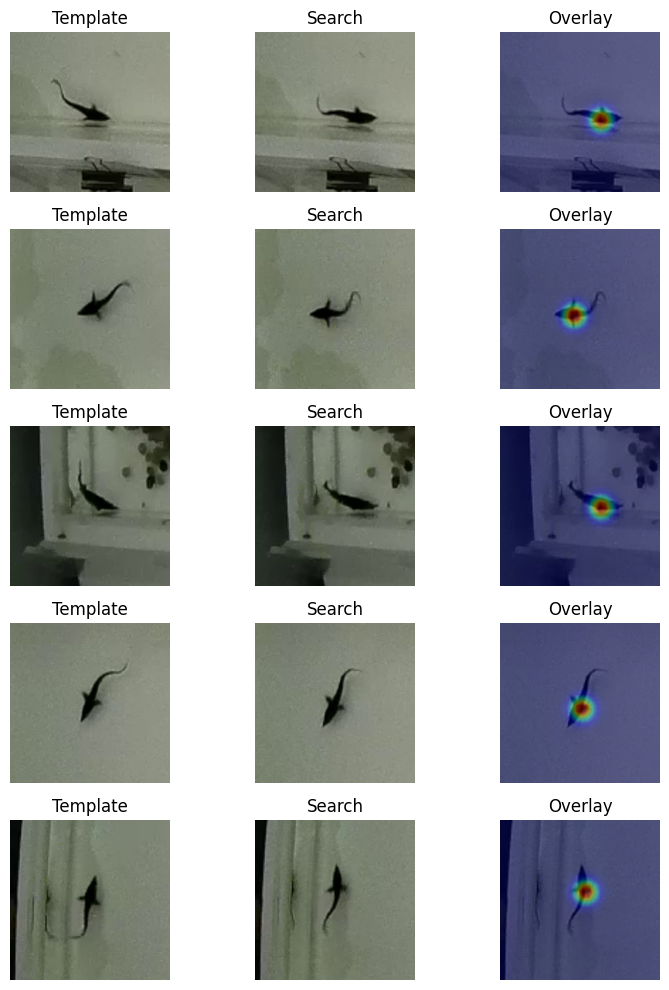

In [5]:
N = 5  # Number of samples to visualize

fig, axes = plt.subplots(N, 3, figsize=(8, 2 * N))

for i in range(N):
    idx = random.randint(0, len(val_dataset) - 1)
    template, search, heatmap = val_dataset[idx]

    template_img = TF.to_pil_image(denormalize(template))
    search_img = TF.to_pil_image(denormalize(search))
    heatmap_np = heatmap.squeeze().numpy()

    # Resize the heatmap to match the search image size
    search_h, search_w = search_img.size
    heatmap_np = cv2.resize(heatmap_np, (search_w, search_h), interpolation=cv2.INTER_LINEAR)

    # Normalize heatmap for visualization
    heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    # Overlay: blend heatmap over search image
    search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()
    heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]  # use jet colormap
    overlay = 0.6 * search_np + 0.4 * heatmap_rgb
    overlay = np.clip(overlay, 0, 1)

    axes[i, 0].imshow(template_img)
    axes[i, 0].set_title("Template")
    axes[i, 1].imshow(search_img)
    axes[i, 1].set_title("Search")
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Model loaded and moved to device:", device)

unet = EfficientUNet()
unet.load_state_dict(torch.load("../data/models/model_efficient_unet_2025-04-04.pth", map_location=device))
unet.eval()
unet.to(device);

# Freeze up UNet, we don't want to train it.
for name, param in unet.named_parameters():
    param.requires_grad = False

model = SiameseTracker(unet).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def weighted_bce_with_logits(pred, target, limit=0.5, pos_weight=10.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    # resize

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

Model loaded and moved to device: cuda


In [7]:
model_dir = '../data/models/siamese'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'
epoch_vis = f'{model_dir}/epoch_vis'

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(epoch_vis, exist_ok=True)

In [ ]:
# Training loop
best_val_loss = float('inf')
losses = []

epochs = 30
epoch_save_interval = 1
alpha = 1.25e-2  # weight for centroid distance loss

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Training {epoch + 1}", leave=False)
    for template, search, heatmap in train_bar:
        template = template.to(device)
        search = search.to(device)
        target = heatmap.to(device)

        output = model(template, search)

        mse = weighted_bce_with_logits(output, target)
        cdist, distances = centroid_distance_loss(output, target)
        loss = mse + alpha * cdist

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Validation {epoch + 1}", leave=False)

        for template, search, heatmap in val_bar:
            template = template.to(device)
            search = search.to(device)
            target = heatmap.to(device)

            output = model(template, search)

            mse = weighted_bce_with_logits(output, target)
            cdist, distances = centroid_distance_loss(output, target)
            loss = mse + alpha * cdist

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    losses.append((train_loss, val_loss))

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("New best model, saving.")
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))
    
    save_epoch_visualization(model, val_dataset, epoch + 1, device, output_dir=epoch_vis, N=20)


KeyboardInterrupt: 

In [ ]:
# 7. Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))
model.eval()
model.to(device);

In [ ]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for templates, searches, heatmaps in tqdm(val_loader, desc="Evaluating"):
        templates = templates.to(device)
        searches = searches.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(templates, searches))

        heatmaps = F.interpolate(heatmaps, size=templates.shape[2:], mode='bilinear', align_corners=False)
        preds = F.interpolate(preds, size=templates.shape[2:], mode='bilinear', align_corners=False)

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(templates)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()
            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = templates[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


In [ ]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    print(f"GT Value at center: {gt_value_center:.2f}, Pred Value at center: {p_value_center:.2f}")

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

In [ ]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

In [ ]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)